In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Full_rasch():
    def __init__(self, INIT):
        
        self.w= INIT['w']
        self.e_1=INIT['e_1']
        self.I_e=self.e_1*1e3*1e6 #!!!!!
        self.w_2=INIT['w_2']
        self.I_e_2=INIT['I_e_2']
        self.m_b=INIT['m_b']
        self.F_0=INIT['F_0'] # начальная пористость заряда
        self.R_i=INIT['R_i'] #  характерный размер моноблока (длина моноблока)
        
        self.S_0= 152 / 163 / 1600 / self.e_1
        
        # Исходные данные
        self.d=0.130
        self.q=14.7
        self.fi_1=1.02
        self.n_s=1
        self.S=np.pi*self.d**2/4*self.n_s
        self.p_fors=15e6
        self.p_0=5e6
        self.W_0=18.7*1e-3
        self.f_0=1.225*1e6
        self.alpha=0.97*1e-3
        self.f_2=1.225*1e6
        self.alpha_2=0.97*1e-3
        self.rho_b= 1100 # плотность ингибитора
        self.Q_b= 600*1e3 # Дж/кг колличество тепла, необходимое для удаления плёнки = нагрев + разложение

        self.lamda_p=0.25  # коэффициент теплопроводности (пороха ?)
        self.T_i=630  # температура на поверхности горения
        self.T_0= 293  # начальная температура пороха

        self.rho_0=1600 # плотность пороха
        self.rho_02=1600
        self.rho_i=1200 # плотность пороха
        self.gamma=1.223  #показатель адиабаты продуктов горения


        #коэффициенты формы моноблока
        self.hi_i =1
        self.lamda_i=0
        self.mu_i=0
        self.Y_j_e=1
        self.hi_zerno_1=1
        self.lamda_zerno_1=0
        self.hi_zerno_2=0
        self.lamda_zerno_2=0
        self.Z_e_zerno=1
        self.psi_s=self.hi_zerno_1*(1+self.lamda_zerno_1)

        #коэффициенты формы насыпной части заряда
        self.hi_2 = 1
        self.lamda_2 = 0
        self.mu_2=0
        self.Z_e_2=1
        
        self.dt=1e-5
        
        
        self.a_0=0.34 # для определения sigma_0
        self.C_sw=26.4+0 # м/c - согласование с экспериментом по скорости
        self.d_p0=1e-4 # м - переводной коэффициент
        self.a_u=1
        self.a_q=10 # ? согласующий параметр
        self.B_N=0.08 # const
        self.a_2=1.43
        self.a_1=70 # коэффициент, описывающий скорость охвата зерна горением
        
        
        # предварительные вычисления
        self.f=self.f_0*(1-self.a_2*self.m_b)
        self.sigma_0=self.a_0*(self.F_0)**0.5 # const < 1. Учит-т, что пов-сть пор < пов-сти зёрен на величину площади пятен контакта зёрен
        #sigma_0=a_ksi*(F_0)**0.5
        self.d_p=4/(self.S_0*self.sigma_0)*(1/self.rho_i-1/self.rho_0) # диаметр пор
        
                
        self.p_mass=np.array([self.p_0])
        self.w_mass=np.array([0])
        self.I=np.array([-3])
        self.W_=np.array([0])
        self.U_g_=np.array([0])
        
        self.fi=self.fi_1+1/3*(self.w+self.w_2)/self.q
           
    def F(Z):
        if Z<=1:
            return 1
        else:
            return 0

    def Etta(self, Z):
        etta=self.hi_zerno_1*Z*(1+self.lamda_zerno_1*Z)*Full_rasch.F(Z)+(
            self.psi_s+self.hi_zerno_2*(Z-1)*(1+self.lamda_zerno_2*(Z-1))
        )*(1-Full_rasch.F(Z))
        return etta

    def Psi(self, Y_j, W, Z, w_mass, t, u_p):
        Y, dY= np.linspace(0, Y_j, 300, retstep= True)
        Psi=0
        if Y_j==0:
            t_zv=0 # момент прихода фронта воспл-я в слой с координатой Y
            sigma_t_tzv=self.sigma_0+(1-self.sigma_0)/(self.a_1*self.m_b/(self.S_0*self.rho_b))*(t-t_zv) # доля горящей поверхности
            dZ_dt=u_p*sigma_t_tzv/self.e_1*np.heaviside(self.Z_e_zerno-Z, 0)
            return 0, dZ_dt
        for i in range(len(Y)):
            t_zv=Y[i]/(W/self.R_i) # момент прихода фронта воспл-я в слой с координатой Y
            sigma_t_tzv=self.sigma_0+(1-self.sigma_0)/(self.a_1*self.m_b/(self.S_0*self.rho_b))*(t-t_zv) # доля горящей поверхности
            dZ_dt=u_p*sigma_t_tzv/self.e_1*np.heaviside(self.Z_e_zerno-Z, 0)
            etta=Full_rasch.Etta(self, Z)
            Psi+=self.hi_i*etta*(1+2*self.lamda_i*Y[i]+3*self.mu_i*(Y[i])**2)*dY
        if Psi >1:
            Psi=1
        return Psi, dZ_dt
    def U_p(self, p):
        return self.e_1/self.I_e*p
    def Gb(self, u_p): 
        return self.m_b*self.Q_b/self.S_0+self.lamda_p*(self.T_i-self.T_0)/(2*u_p)
    def Calc(self, t, Y):

        Y_j, Z, z_2, X, U=Y
        #print(Y)
        p=self.p_mass[-1]
        u_p=Full_rasch.U_p(self, p)
        G_b=Full_rasch.Gb(self, u_p) # Дж/м2 колличество тепла на 1 пов-сти пор, необх для воспл-я ингибированного пороха
        dzeta = 8*(self.gamma-1)*G_b/(self.d_p*p) # б.р. пар-р, хар-ий эффект затрат тепла на удаление плёнки ингибитора

        W=self.C_sw*((self.d_p/self.d_p0)/(dzeta*(1+dzeta)**2))**(1/3) # скорость конвективного горения
        #w_mass=np.append(w_mass, W)

        U_g=self.a_u*self.C_sw*(self.d_p/self.d_p0)**(1/3)
        m=0
        A=-100
        t_ig=0

        B = self.a_q*(self.gamma-1)/(self.B_N*U_g)*G_b
        while A < B:
            if m < t//self.dt:
                t_ig=m*self.dt
                SUM=0
                for i in range(m):
                    SUM += self.p_mass[i]*self.dt
                A=SUM
                m+=1
                W=self.C_sw*((self.d_p/self.d_p0)/(dzeta*(1+dzeta)**2))**(1/3) # скорость конвективного горения
            else:
                t_ig=100
                W=0
                break

        if t < t_ig:
            dY_j_dt=0   #Y_j - координата фронта воспламенения
        else:
            dY_j_dt=W/self.R_i*np.heaviside(self.Y_j_e-Y_j, 0)

        M_j=self.hi_i*Y_j*(1+self.lamda_i*Y_j+self.mu_i*Y_j**2)
        psi, dZ_dt=Full_rasch.Psi(self, Y_j, W, Z, self.w_mass, t, u_p)


        psi_2=self.hi_2*z_2*(1+self.lamda_2*z_2+self.mu_2*z_2**2)
        dz_2_dt=p/self.I_e_2*np.heaviside(self.Z_e_2-z_2, 0)

        A_=self.f*self.w*psi+self.f_2*self.w_2*psi_2-(self.gamma-1)*self.fi*self.q*U**2/2
        B_=self.W_0+self.w*( M_j*(1/self.rho_i-1/self.rho_0)-1/self.rho_i+psi*(1/self.rho_0-self.alpha))+self.w_2*psi_2*(1/self.rho_02-self.alpha_2)+self.S*X
        p=A_/B_+self.p_0

        if self.I[-1] %4 ==0 and self.I[-1] >=0:
            self.p_mass=np.append(self.p_mass, p)
            self.W_=np.append(self.W_, W)
            self.U_g_=np.append(self.U_g_, U_g)

        if p < self.p_fors:
            dU_dt=0
        else:
            dU_dt=p*self.S/(self.fi*self.q)
        dX_dt=U

        self.I=np.append(self.I, self.I[-1]+1)

        return np.array([dY_j_dt, dZ_dt, dz_2_dt, dX_dt, dU_dt])

    def rk4(self, init, sys, t0, dt, n):

        # declaration

        t = np.zeros(n)
        m = len(init) + 1
        res = np.zeros((n, m))

        # initialization

        i = 0
        X = init
        t[i] = t0
        res[i, 0] = t[i]
        res[i, 1:m] = X

        # main loop

        while res[i,4] < 6 and i < n - 1:
            k1 = sys(self, t[i], X)
            k2 = sys(self, t[i] + 0.5*dt, X + k1*0.5*dt)
            k3 = sys(self, t[i] + 0.5*dt, X + k2*0.5*dt)
            k4 = sys(self, t[i] + dt, X + k3*dt)
            i += 1
            X += (k1 + 2*k2 + 2*k3 + k4)*dt/6
            t[i] = t[i - 1] + dt
            res[i, 0] = t[i]
            res[i, 1:m] = X

        return res[0:i + 1, :]
    
    def get_res(self):    
        init=np.array([0.0, 0.0, 0.0, 0.0, 0.0])
        n=int(6000)

        res=Full_rasch.rk4(self, init, Full_rasch.Calc, 0, self.dt, n)

        t=res[:,0]
        x=res[:, -2]
        v=res[:, -1]
        Z=res[:, 2]
        z_2=res[:, 3]
        Y_j=res[:, 1]
        p=self.p_mass

        return np.array([t, x, v, p, Z, z_2, Y_j])

In [3]:
# INIT = {
#     'w': 15.2,
#     'e_1': 1.723*1e-3,
#     'w_2': 4.498,
#     'I_e_2': 1.587*1e6,
#     'm_b': 0.057,
#     'R_i': 
#     'F_0': 
# }


#1626
# INIT = {
#     'w': 15.266,
#     'e_1': 1.69*1e-3,
#     'w_2': 4.469,
#     'I_e_2': 1.634*1e6,
#     'm_b': 0.0597,
#     'R_i': 0.0199,
#     'F_0': 0.1403
# }

INIT = {
    'w': 15.113,
    'e_1': 1.665*1e-3,
    'w_2': 4.462,
    'I_e_2': 1.747*1e6,
    'm_b': 0.0588,
    'R_i': 0.02038,
    'F_0': 0.1479
}



res = Full_rasch(INIT).get_res()


In [4]:
t=res[0]
x=res[1]
v=res[2]
p=res[3]
Z=res[4]
z_2=res[5]
Y_j=res[6]

In [5]:
print(v[-1])
print(max(p)/1e6)

1635.3517079883052
501.3786611316821


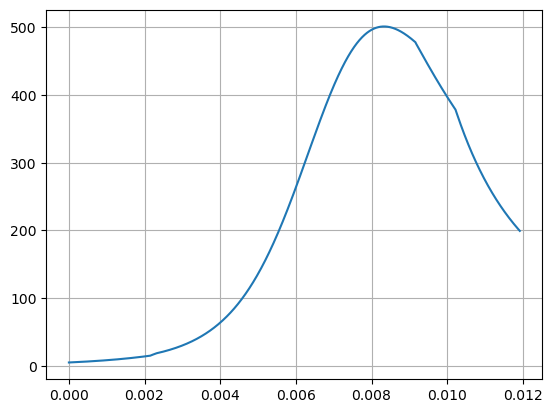

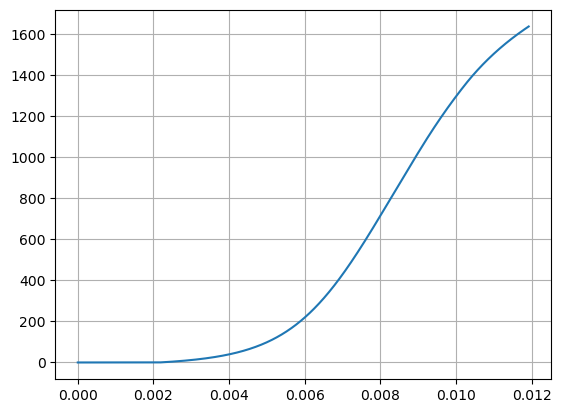

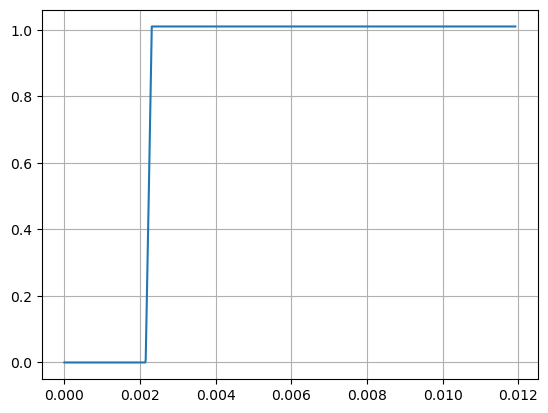

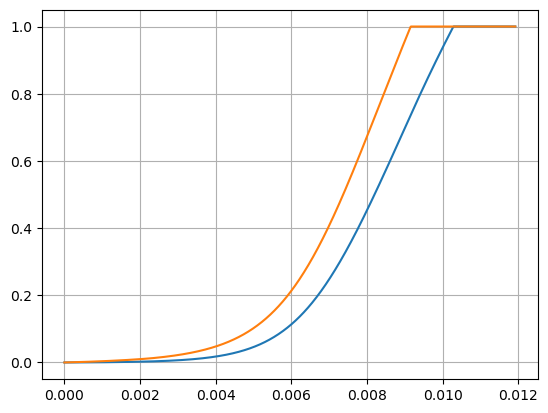

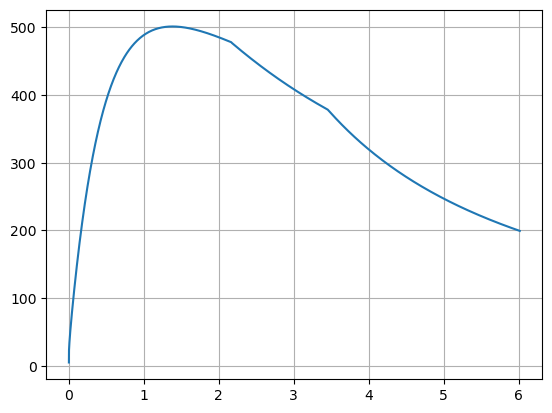

In [6]:
plt.plot(t, p/1e6)
# plt.xlim(0,0.0005)
# plt.ylim(0,10)
plt.grid()
plt.show()

plt.plot(t, v)
plt.grid()
plt.show()

plt.plot(t, Y_j)
plt.grid()
plt.show()


plt.plot(t, Z)
plt.plot(t, z_2)
plt.grid()
plt.show()


plt.plot(x, p/1e6)
plt.grid()
plt.show()

In [7]:

k_kr=2 #поправка на крешерный прибор
w_q=1.022
q=14.65

init={
    'v_d_treb':1600,
    
    'T_0': 288.15,
    
    'd': 0.130,
    'q': q,
    'fi_1': 1.02,
    'p_0': 15e6,
    'l_d': 6,
    'n_s': 1,
    'p_0a': 1e5, # атмосферное давление
    'c_0a': 340, #скорость звука в воздухе
    'k_a': 1.4, # показатель адиабаты воздуха
    
    'dt': 1e-6,
    'n': int(1e6),
    
    'W_0': 18.7*1e-3,
                   
    # ПОД-35/5К
    'w_1': w_q*q,
    'I_e_1': 1.85*1e6,
    'f_1': 1.225e6,
    'delta_1': 1620,
    'b_1': 0.97*1e-3,
    'z_e_1': 1,
    'kappa_1_1': 1,
    'lamda_1_1': 0,
    'kappa_2_1': 0,
    'lamda_2_1': 0,
    'k_g_1': 1.223,
    'k_I_1': 0.0020,
    'k_f_1':0.00030,
    'T_c_1': 3586,


    # 20/1 Тр ПОД-35/5К
    'w_2': 0,
    'I_e_2': 1.17*1e6,
    'f_2': 1.159e6,
    'delta_2': 1600,
    'b_2': 1.079*1e-3,
    'z_e_2': 1,
    'kappa_1_2': 1,
    'lamda_1_2': 0,
    'kappa_2_2': 0,
    'lamda_2_2': 0,
    'k_g_2': 1.231,
    'k_I_2': 0.0020,
    'k_f_2':0.00030,
    'T_c_2': 3387,
    
    # пламягаситель ВТХ-20
    'w_3': 0,
    'I_e_3': 0.39*1e6,
    'f_3': 0.771e6,
    'delta_3': 1600,
    'b_3': 0.971*1e-3,
    'z_e_3': 1,
    'kappa_1_3': 1.086,
    'lamda_1_3': -0.08,
    'kappa_2_3': 0,
    'lamda_2_3': 0,
    'k_g_3': 1.227,
    'k_I_3': 0.0022,
    'k_f_3':0.0007,
    'T_c_3': 1875,
    
    
    #воспламенитель КЗДП-2
    'k_ign': 1.22,
    'b_ign':0.6*1e-3,
    'f_ign': 0.26*1e6,
    'T_ign': 2427,
    'delta_ign': 1700,
    'w_ign': 0.1,
    
    
}

In [8]:
class Raschet():
    def __init__(self, INIT):
        
        self.v_d_treb=INIT['v_d_treb']
        
        self.T_0=INIT['T_0']
        
        self.d=INIT['d']
        self.q=INIT['q']
        self.fi_1=INIT['fi_1']
        self.p_0=INIT['p_0']
        self.l_d=INIT['l_d']
        self.n_s=INIT['n_s']
        self.S=np.pi*self.d**2*self.n_s/4
        
        self.p_0a=INIT['p_0a']
        self.c_0a=INIT['c_0a']
        self.k_a=INIT['k_a']

        self.W_0=INIT['W_0']

        self.l_0=self.W_0/self.S

        self.w_1=INIT['w_1']
        self.I_e_1=INIT['I_e_1']
        self.f_1=INIT['f_1']
        self.delta_1=INIT['delta_1']
        self.b_1=INIT['b_1']
        self.z_e_1=INIT['z_e_1']
        self.kappa_1_1=INIT['kappa_1_1']
        self.lamda_1_1=INIT['lamda_1_1']
        self.kappa_2_1=INIT['kappa_2_1']
        self.lamda_2_1=INIT['lamda_2_1']
        self.k_1=INIT['k_g_1']
        self.k_I_1=INIT['k_I_1']
        self.k_f_1=INIT['k_f_1']
        self.T_c_1=INIT['T_c_1']
        
        self.psi_s_1=self.kappa_1_1*(1+self.lamda_1_1)
        self.R_g_1=self.f_1/self.T_c_1
        self.I_e_1=self.I_e_1*(1-self.k_I_1*(self.T_0-288.15))
        self.f_1=self.f_1*(1+self.k_f_1*(self.T_0-288.15))
        
        self.w_2=INIT['w_2']
        self.I_e_2=INIT['I_e_2']
        self.f_2=INIT['f_2']
        self.delta_2=INIT['delta_2']
        self.b_2=INIT['b_2']
        self.z_e_2=INIT['z_e_2']
        self.kappa_1_2=INIT['kappa_1_2']
        self.lamda_1_2=INIT['lamda_1_2']
        self.kappa_2_2=INIT['kappa_2_2']
        self.lamda_2_2=INIT['lamda_2_2']
        self.k_2=INIT['k_g_2']
        self.k_I_2=INIT['k_I_2']
        self.k_f_2=INIT['k_f_2']
        self.T_c_2=INIT['T_c_2']
        self.psi_s_2=self.kappa_1_2*(1+self.lamda_1_2)
        self.R_g_2=self.f_2/self.T_c_2        
        self.I_e_2=self.I_e_2*(1-self.k_I_2*(self.T_0-288.15))
        self.f_2=self.f_2*(1+self.k_f_2*(self.T_0-288.15))
           
        
        self.w_3=INIT['w_3']
        self.I_e_3=INIT['I_e_3']
        self.f_3=INIT['f_3']
        self.delta_3=INIT['delta_3']
        self.b_3=INIT['b_3']
        self.z_e_3=INIT['z_e_3']
        self.kappa_1_3=INIT['kappa_1_3']
        self.lamda_1_3=INIT['lamda_1_3']
        self.kappa_2_3=INIT['kappa_2_3']
        self.lamda_2_3=INIT['lamda_2_3']
        self.k_3=INIT['k_g_3']
        self.k_I_3=INIT['k_I_3']
        self.k_f_3=INIT['k_f_3']
        self.T_c_3=INIT['T_c_3']
        self.psi_s_3=self.kappa_1_3*(1+self.lamda_1_3)
        self.R_g_3=self.f_3/self.T_c_3  
        self.I_e_3=self.I_e_3*(1-self.k_I_3*(self.T_0-288.15))
        self.f_3=self.f_3*(1+self.k_f_3*(self.T_0-288.15))        
        
        self.k_ign=INIT['k_ign']
        self.b_ign=INIT['b_ign']
        self.f_ign=INIT['f_ign']
        self.T_ign=INIT['T_ign']
        self.R_ign=self.f_ign/self.T_ign
        delta_ign=INIT['delta_ign']
        #self.p_ign=INIT['p_ign']
        self.w_ign=INIT['w_ign']
        
        self.C_1=self.w_1/(self.w_1+self.w_2+self.w_3)      
        self.C_2=self.w_2/(self.w_1+self.w_2+self.w_3)  
        self.C_3=self.w_3/(self.w_1+self.w_2+self.w_3)  
        self.p_ign=1/((self.W_0-self.w_1/self.delta_1-self.w_2/self.delta_2-self.w_3/self.delta_3)/(self.f_ign*self.w_ign)+self.b_ign/self.f_ign)                                    
        #self.w_ign=self.p_ign/self.f_ign*(self.W_0-self.w_1/self.delta_1-self.w_2/self.delta_2-self.w_3/self.delta_3)*(1/(1+self.b_ign*self.p_ign/self.f_ign))
        
        self.dzeta=self.w_ign/(self.w_1+self.w_2+self.w_3)
        self.R_g_sum=self.C_1*self.R_g_1+self.C_2*self.R_g_2+self.C_3*self.R_g_3
        
        self.dt=INIT['dt']
        self.n=INIT['n']
        
        self.fi=self.fi_1+1/3*(self.w_1+self.w_2+self.w_3+self.w_ign)/self.q
        
        self.p_m=np.array([self.p_ign])
        self.p_vspom=np.array([self.p_ign])
        self.psi_1=np.array([0])
        self.psi_2=np.array([0])
        self.psi_3=np.array([0])
        self.p_vozd=np.array([self.p_0a])
        self.A_pa=0
        self.index=np.array([0])
        
    def H(self, z, z_e):
        if z > z_e:
            return 0
        else:
            return 1
        
    def H_1(z):
        if z<=1:
            return 1
        else:
            return 0
    
    def H_2(self,p, p_a):
        if p-self.p_0a-self.p_0-p_a >0:
            return 1
        else:
            return 0
    
    def Psi(self, z, kappa_1, lamda_1, kappa_2, lamda_2, psi_s):
        psi=kappa_1*z*(1+lamda_1*z)*Raschet.H_1(z)+(psi_s+kappa_2*(z-1)*(1+lamda_2*(z-1)))*(1-Raschet.H_1(z))
        return psi
    
    
    def calc(self, t, Y): #Y0=x,Y1=v, Y2=zi
        self.index=np.append(self.index, self.index[-1]+1)
        x=Y[0]
        v=Y[1]
        z_1=Y[2]
        z_2=Y[3]
        z_3=Y[4]
        Q_w=Y[5]
        etta_T=Y[6]
        
        dx_dt=v
        
        psi_1=Raschet.Psi(self, z_1, self.kappa_1_1, self.lamda_1_1, self.kappa_2_1, self.lamda_2_1, self.psi_s_1)
        psi_2=Raschet.Psi(self, z_2, self.kappa_1_2, self.lamda_1_2, self.kappa_2_2, self.lamda_2_2, self.psi_s_2)
        psi_3=Raschet.Psi(self, z_3, self.kappa_1_3, self.lamda_1_3, self.kappa_2_3, self.lamda_2_3, self.psi_s_3)
        
        
        CDE=self.C_1*self.R_g_1*psi_1 + self.C_2*self.R_g_2*psi_2 + self.C_3*self.R_g_3*psi_3
        EFG=self.C_1*self.R_g_1*psi_1/(self.k_1-1) + self.C_2*self.R_g_2*psi_2/(self.k_2-1) + self.C_3*self.R_g_3*psi_3/(self.k_3-1)
        
        if CDE == 0:
            k_sum=self.k_ign
        else:
            k_sum=1+(CDE)/(EFG)
        
        self.psi_1=np.append(self.psi_1, psi_1)
        self.psi_2=np.append(self.psi_2, psi_2)
        self.psi_3=np.append(self.psi_3, psi_3)
        
        Kf_1=self.k_a*(self.k_a+1)/4*(v/self.c_0a)**2
        Kf_2=self.k_a*v/self.c_0a*(1+((self.k_a+1)/4*v/self.c_0a)**2)**0.5
        p_a=self.p_0a*(1+Kf_1+Kf_2)
        self.p_vozd=np.append(self.p_vozd, p_a)
        if self.index[-1] % 4 == 0:
            self.A_pa+=p_a*self.S*v*self.dt                                       
        
        W_c=self.w_1*(1/self.delta_1-(1/self.delta_1-self.b_1)*psi_1) + self.w_2*(1/self.delta_2-(1/self.delta_2-self.b_2)*psi_2) + self.w_3*(1/self.delta_3-(1/self.delta_3-self.b_3)*psi_3) + self.w_ign*self.b_ign
        B=self.W_0+self.S*x-W_c
     
        T=self.p_vspom[-1]/self.R_g_sum*B/(self.w_1*psi_1+self.w_2*psi_2+self.w_3*psi_3+self.w_ign)
        T_w=self.T_0+etta_T**0.5
        mu_0=0.175*1e-4
        T_0s=273
        T_cs=628
        mu=mu_0*((T_cs+T_0s)/(T_cs+T))*(T/T_0s)**1.5
        Re=(self.w_1+self.w_2+self.w_3+self.w_ign)*v*self.d/(2*(x+self.l_0)*self.S*mu)
        Pr=0.74
        Nu=0.023*Re**0.8*Pr**0.4
        lamda_g=0.2218
        c_b=500
        rho_b=7900
        lamda_b=40
        
        nu_etta=-2*v*etta_T/(x+self.l_0)
        detta_T_dt=(2*(Nu*lamda_g)**2)/(self.d**2*c_b*rho_b*lamda_b)*(T-self.T_0-etta_T**0.5)+nu_etta
        q_w=Nu*lamda_g/self.d*(T-T_w)
        S_w=(self.l_0+x)*np.pi*self.d
        dQ_w_dt=S_w*q_w
        
        A= ( self.p_ign/(self.k_ign-1)*(self.W_0-self.w_1/self.delta_1-self.w_2/self.delta_2-self.w_3/self.delta_3-self.w_ign*self.b_ign) + self.f_1*self.w_1*psi_1/(self.k_1-1) + self.f_2*self.w_2*psi_2/(self.k_2-1) + self.f_3*self.w_3*psi_3/(self.k_3-1) - self.fi*self.q*v**2/2-self.A_pa - Q_w )*(k_sum-1)
        p=A/B
        if self.index[-1] % 4 == 0:   
            self.p_vspom=np.append(self.p_vspom, p)
        
        self.p_m=np.append(self.p_m, p)
        dz_1_dt=p/self.I_e_1*Raschet.H(self, z_1, self.z_e_1)
        dz_2_dt=p/self.I_e_2*Raschet.H(self, z_2, self.z_e_2)   
        dz_3_dt=p/self.I_e_3*Raschet.H(self, z_3, self.z_e_3)   
        
        dv_dt=(p-self.p_0a)*self.S/self.fi/self.q*Raschet.H_2(self,p, p_a)              
        #print(np.array([dx_dt, dv_dt, dz_1_dt, dz_2_dt, dz_3_dt, dQ_w_dt, detta_T_dt]))
        return np.array([dx_dt, dv_dt, dz_1_dt, dz_2_dt, dz_3_dt, dQ_w_dt, detta_T_dt])
        
    def rk4(self, init, sys, t0, dt, n):
        t=np.zeros(n)
        m=len(init)+1
        res=np.zeros((n,m))
        
        i=0
        X=init
        t[i]=t0
        res[i, 0]=t[i]
        res[i, 1:m]=X
        
        while res[i,1] <= self.l_d and i<n-1:
            k1=sys(self, t[i], X)
            k2=sys(self, t[i]+0.5*dt, X+0.5*k1*dt)
            k3=sys(self, t[i]+0.5*dt, X+k2*0.5*dt)
            k4=sys(self, t[i]+dt, X+k3*dt)
            i+=1
            X=X+(k1+2*k2+2*k3+k4)*dt/6
            t[i]=t[i-1]+dt
            
            res[i,0]=t[i]
            res[i, 1:m]=X  
        return res[0:i+1, :]
        
    def get_res(self):
        init=np.array([0, 0, 0, 0, 0, 0,0])
        t0=0
        res = Raschet.rk4(self,init, Raschet.calc, t0, self.dt, self.n)
        full_res={
            't':res[:, 0],
            'x':res[:, 1],
            'v':res[:, 2],
            'z_1':res[:, 3],
            'z_2':res[:, 4],
            'z_3':res[:, 5],
            'p':self.p_m[0::4],
            'psi_1':self.psi_1[0::4],
            'psi_2':self.psi_2[0::4],
            'psi_3':self.psi_3[0::4],
            'p_a': self.p_vozd[0::4],
            'A_pa': self.A_pa
        }
        return  full_res

In [9]:
res=Raschet(init).get_res()
t_class=res['t']
x_class=res['x']
v_class=res['v']
p_class=res['p']
psi_1_class=res['psi_1']
psi_2_class=res['psi_2']
psi_3_class=res['psi_3']
z_1_class=res['z_1']
z_2_class=res['z_2']
z_3_class=res['z_3']

In [10]:
print(v[-1])
print(v_class[-1])
print(max(p)/1e6)





1635.3517079883052
1586.0283318147756
501.3786611316821


In [11]:
print(t_class*1e3)

[0.0000e+00 1.0000e-03 2.0000e-03 ... 1.0537e+01 1.0538e+01 1.0539e+01]


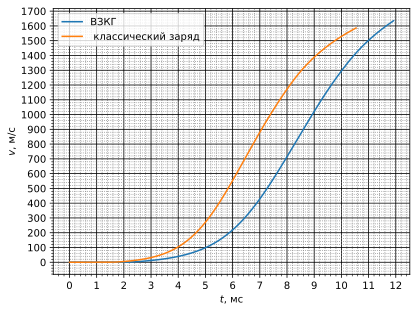

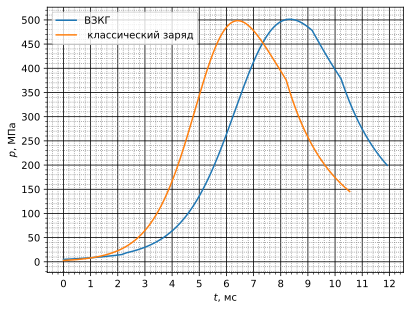

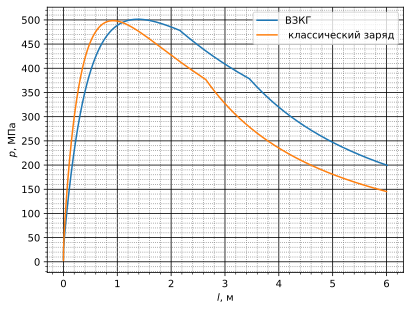

NameError: name 't_2' is not defined

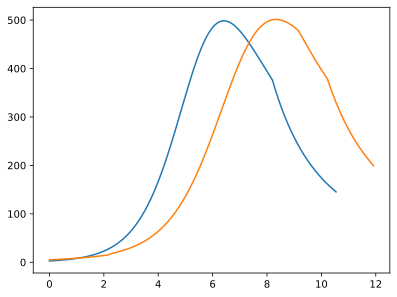

In [12]:
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'svg'


# графики для +15


fig, ax=plt.subplots()
ax.plot(t*1e3, v, label='ВЗКГ')
ax.plot(t_class*1e3, v_class, label=' классический заряд')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.001*1e3))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.0005*1e3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))
ax.grid(which='major', color='black')
ax.minorticks_on()
ax.grid(which='minor', color='gray', linestyle = ':')

plt.xlabel('$t$, мс')
plt.ylabel('$v$, м/с')

#plt.plot(t_class, v_class, label='1. Классический заряд')
#plt.plot(t, v, label='2. ВЗКГ')
#plt.plot(t_2, v_2, label='классич. заряд с массой ВЗКГ')
plt.legend()
#plt.grid()
plt.show()



fig, ax=plt.subplots()
ax.plot(t*1e3, p/1e6, label='ВЗКГ')
ax.plot(t_class*1e3, p_class/1e6, label=' классический заряд')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.001*1e3))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.0005*1e3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.grid(which='major', color='black')
ax.minorticks_on()
ax.grid(which='minor', color='gray', linestyle = ':')


#plt.plot(t_class, p_class/1e6, label='1. Классический заряд')
#plt.plot(t, p/1e6, label='2. ВЗКГ')
#plt.plot(t_2, p_2/1e6, label='классич. заряд с массой ВЗКГ')
plt.xlabel('$t$, мс')
plt.ylabel('$p$, МПа')
plt.legend()
#plt.grid()
plt.show()


fig, ax=plt.subplots()
ax.plot(x, p/1e6, label='ВЗКГ')
ax.plot(x_class, p_class/1e6, label=' классический заряд')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.grid(which='major', color='black')
ax.minorticks_on()
ax.grid(which='minor', color='gray', linestyle = ':')
#plt.plot(x_class, p_class/1e6, label='1. Классический заряд')
p#lt.plot(x, p/1e6, label='2. ВЗКГ')
#plt.plot(x_2, p_2/1e6, label='классич. заряд с массой ВЗКГ')
plt.xlabel('$l$, м')
plt.ylabel('$p$, МПа')
plt.legend()
#plt.grid()
plt.show()

plt.plot(t_class*1e3, p_class/1e6, label='1. Классический заряд')
plt.plot(t*1e3, p/1e6, label='2. ВЗКГ')
plt.plot(t_2, p_2/1e6, label='3. Классич. заряд с массой ВЗКГ')
plt.xlabel('$t$, мс')
plt.ylabel('$p$, МПа')
plt.legend()
plt.grid()
plt.show()





# plt.plot(t, z_1)
# plt.grid()
# plt.show()

print( 'дульная скорость для классического заряда' ,np.round(v_class[-1],1), 'м/с')
print( 'дульная скорость для ВЗКГ' ,np.round(v[-1],1), 'м/с')
print('max среднебал. давление для классического заряда', np.round(max(p_class)/1e6, 1), 'МПа')
print('max среднебал. давление для ВЗКГ',np.round(max(p)/1e6, 1), 'МПа')
# print('дульное среднебал. давление при +15' ,p_class[-1]/1e6)
# print('время начала движения', t_class[list(v_class).index(v_class[v_class>0][0])])
# print('время достижения макс. давления', t[list(p_class).index(max(p_class))] )
# print('время вылета снаряда', t_class[-1])
# print(res['x'][-1])

In [ ]:
print(v_class[-1])
print(v[-1])